<a href="https://colab.research.google.com/github/Uemerson/experiments-tensorflow/blob/main/cnn_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST dataset - CNN with MaxPooling

In [1]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshape the data to have a single channel
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# Normalize data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on first 50% of the training set
x_train = x_train[:int(0.5 * len(x_train))]
y_train = y_train[:int(0.5 * len(y_train))]

# Train the model
r = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))


11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/10
938/938 [==============================] - 26s 10ms/step - loss: 0.2111 - accuracy: 0.9347 - val_loss: 0.0607 - val_accuracy: 0.9822
Epoch 2/10
938/938 [==============================] - 5s 5ms/step - loss: 0.0712 - accuracy: 0.9777 - val_loss: 0.0461 - val_accuracy: 0.9849
Epoch 3/10
938/938 [==============================] - 6s 6ms/step - loss: 0.0513 - accuracy: 0.9837 - val_loss: 0.0431 - val_accuracy: 0.9858
Epoch 4/10
938/938 [==============================] - 5s 5ms/step - loss: 0.0407 - accuracy: 0.9860 - val_loss: 0.0314 - val_accuracy: 0.9892
Epoch 5/10
938/938 [==============================] - 6s 6ms/step - loss: 0.0320 - accuracy: 0.9892 - val_loss: 0.0338 - val_accuracy: 0.9901
Epoch 6/10
938/938 [==============================] - 6s 6ms/step - loss: 0.0267 - accuracy: 0.9917 - val_loss: 0.0367 - val_accuracy: 0.9881
Epoch 7/10
938/938 [==============================] - 6s 6ms/step - loss: 0.0229 

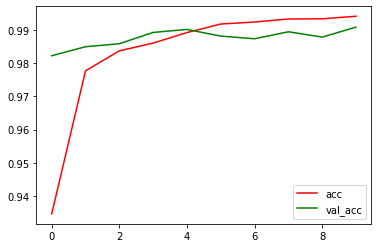

In [2]:
import matplotlib.pyplot as plt

# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc', color='red')
plt.plot(r.history['val_accuracy'], label='val_acc', color='green')
plt.legend()

In [3]:
#  Get the accuracy of the last epoch
r.history['accuracy'][-1]

0.9940666556358337

In [4]:
import numpy as np

# Make predictions on the test set
y_pred = model.predict(x_test)

# Get the class labels with highest probability
y_pred_labels = np.argmax(y_pred, axis=1)

313/313 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 60ms/step


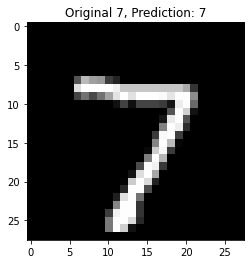

1/1 [==============================] - 0s 19ms/step


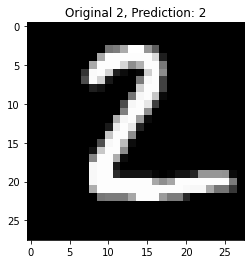

1/1 [==============================] - 0s 20ms/step


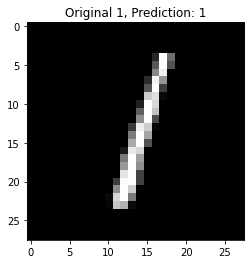

1/1 [==============================] - 0s 21ms/step


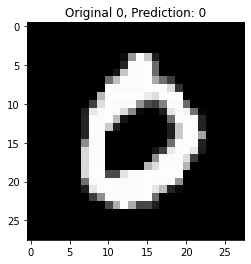

1/1 [==============================] - 0s 22ms/step


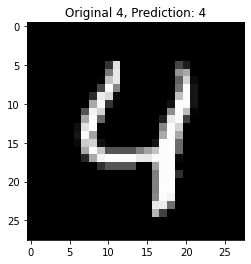

1/1 [==============================] - 0s 19ms/step


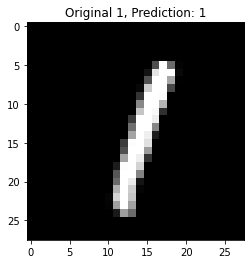

In [5]:
for i in range(0,6):
  img = x_test[i]
  img = np.expand_dims(img, axis=0)

  # Make prediction on individual image
  prediction = model.predict(img)

  # Get the class label with highest probability
  prediction_label = np.argmax(prediction, axis=1)
  
  # Get the original label of the image
  original_label = y_test[i]

  # Plot the image and the prediction
  plt.imshow(img.reshape(28, 28), cmap='gray')
  plt.title('Original {}, Prediction: {}'.format(np.where(original_label == 1)[0][0], prediction_label[0]))
  plt.show()

# MNIST dataset - CNN with BPCA Layer

In [24]:
import tensorflow as tf
import numpy as np

# class MinMaxPooling2D(tf.keras.layers.Layer):
#     def __init__(self, pool_size=(2,2), strides=None, **kwargs):
#         super(MinMaxPooling2D, self).__init__(**kwargs)
#         self.pool_size = pool_size
#         self.strides = strides or pool_size

#     def call(self, inputs):
#         max_pool = tf.keras.backend.pool2d(inputs, pool_size=self.pool_size, strides=self.strides, padding='same', pool_mode='max')
#         min_pool = tf.keras.backend.pool2d(inputs, pool_size=self.pool_size, strides=self.strides, padding='same', pool_mode='avg')
#         output = tf.keras.layers.concatenate([max_pool, min_pool], axis=-1)
#         return output

#     def get_config(self):
#         config = super(MinMaxPooling2D, self).get_config()
#         config.update({'pool_size': self.pool_size, 'strides': self.strides})
#         return config

class BPCALayer(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, stride=2, **kwargs):
      super(MinMaxPooling2D, self).__init__(**kwargs)
      self.pool_size = pool_size
      self.stride = stride

    def call(self, inputs):
      output_matrix = self.make_blocks(inputs, pool_size=self.pool_size, stride=self.stride)

      # make blocks
      n = inputs.shape[1]
      m = inputs.shape[2]
      output_matrix = []
      for i in range(0, n, self.stride):
          for j in range(0, m, self.stride):
              # fix out of bounds
              if i + self.pool_size > n or j + self.pool_size > m:
                  continue
              output_matrix.append(inputs[i:i + self.pool_size, j:j + self.pool_size])

      # output_matrix = np.array(output_matrix)
      output_matrix = tf.convert_to_tensor(output_matrix, tf.float64)
      print(output_matrix.shape)
      output_matrix = tf.reshape(output_matrix.shape[2], output_matrix.shape[3]*output_matrix.shape[4])

      n_components = 1

      data = tf.cast(output_matrix, tf.float64)

      # Normalize the data by subtracting the mean and dividing by the standard deviation
      mean = tf.reduce_mean(data, axis=0)
      std = tf.math.reduce_std(data, axis=0)
      data = (data - mean) / std

      # Perform the Singular Value Decomposition (SVD) on the data
      s, u, v = tf.linalg.svd(data)

      # Extract the first n principal components from the matrix v
      pca_components = v[:, :n_components]

      # Perform the PCA transformation on the data
      transformed_data = tf.matmul(data, pca_components)

      return transformed_data

In [26]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshape the data to have a single channel
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# Normalize data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MinMaxPooling2D())  # replace MaxPooling2D with BPCALayer
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on first 50% of the training set
x_train = x_train[:int(0.5 * len(x_train))]
y_train = y_train[:int(0.5 * len(y_train))]

# Train the model
r = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))


Epoch 1/10
938/938 [==============================] - 18s 8ms/step - loss: 0.1928 - accuracy: 0.9407 - val_loss: 0.0727 - val_accuracy: 0.9763
Epoch 2/10
938/938 [==============================] - 6s 7ms/step - loss: 0.0692 - accuracy: 0.9789 - val_loss: 0.0458 - val_accuracy: 0.9852
Epoch 3/10
938/938 [==============================] - 7s 7ms/step - loss: 0.0466 - accuracy: 0.9850 - val_loss: 0.0444 - val_accuracy: 0.9863
Epoch 4/10
938/938 [==============================] - 6s 7ms/step - loss: 0.0369 - accuracy: 0.9878 - val_loss: 0.0363 - val_accuracy: 0.9883
Epoch 5/10
938/938 [==============================] - 6s 7ms/step - loss: 0.0314 - accuracy: 0.9894 - val_loss: 0.0384 - val_accuracy: 0.9882
Epoch 6/10
938/938 [==============================] - 6s 7ms/step - loss: 0.0244 - accuracy: 0.9920 - val_loss: 0.0370 - val_accuracy: 0.9887
Epoch 7/10
938/938 [==============================] - 6s 7ms/step - loss: 0.0248 - accuracy: 0.9920 - val_loss: 0.0336 - val_accuracy: 0.9909
Epoch

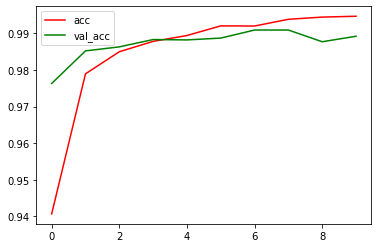

In [27]:
import matplotlib.pyplot as plt

# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc', color='red')
plt.plot(r.history['val_accuracy'], label='val_acc', color='green')
plt.legend()

In [28]:
#  Get the accuracy of the last epoch
r.history['accuracy'][-1]

0.9946666955947876

In [29]:
import numpy as np

# Make predictions on the test set
y_pred = model.predict(x_test)

# Get the class labels with highest probability
y_pred_labels = np.argmax(y_pred, axis=1)

313/313 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 58ms/step


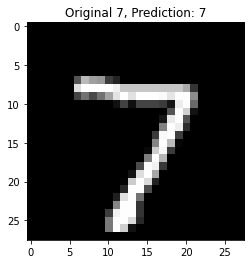

1/1 [==============================] - 0s 21ms/step


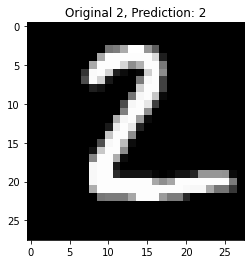

1/1 [==============================] - 0s 19ms/step


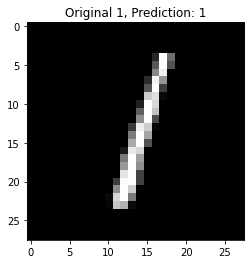

1/1 [==============================] - 0s 20ms/step


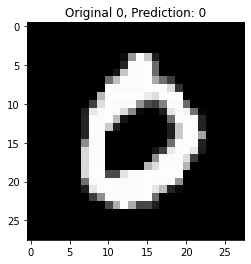

1/1 [==============================] - 0s 20ms/step


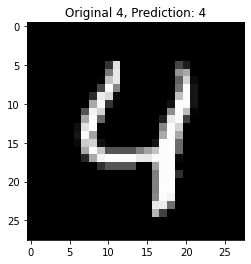

1/1 [==============================] - 0s 19ms/step


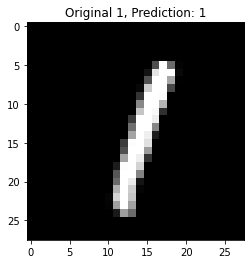

In [30]:
for i in range(0,6):
  img = x_test[i]
  img = np.expand_dims(img, axis=0)

  # Make prediction on individual image
  prediction = model.predict(img)

  # Get the class label with highest probability
  prediction_label = np.argmax(prediction, axis=1)
  
  # Get the original label of the image
  original_label = y_test[i]

  # Plot the image and the prediction
  plt.imshow(img.reshape(28, 28), cmap='gray')
  plt.title('Original {}, Prediction: {}'.format(np.where(original_label == 1)[0][0], prediction_label[0]))
  plt.show()